# COURSE: A deep understanding of deep learning
## SECTION: FFNs (feed-forward networks)
### LECTURE: FFN to classify digits
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202305

In [21]:
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
# import libraries
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

# Change the format from SVG to PNG to avoid the "untrusted SVG" issue
matplotlib_inline.backend_inline.set_matplotlib_formats('png')

# Import and process the data

In [22]:
# import dataset (comes with colab!)
data = np.loadtxt(open('sample_data/mnist_train_small.csv', 'rb'), delimiter=',')
# remove first row (header)
# data = data[1:, :]
print("data shape: ", data.shape)  # should be 20000x785, where the columns are 1 label and 784 pixels
# extract labels (number IDs) and remove from data
labels = data[:, 0]
data = data[:, 1:]

print("labels (data[:,0]): ", labels)
print("labels shape: ", labels.shape)


data shape:  (20000, 785)
labels (data[:,0]):  [6. 5. 7. ... 2. 9. 5.]
labels shape:  (20000,)


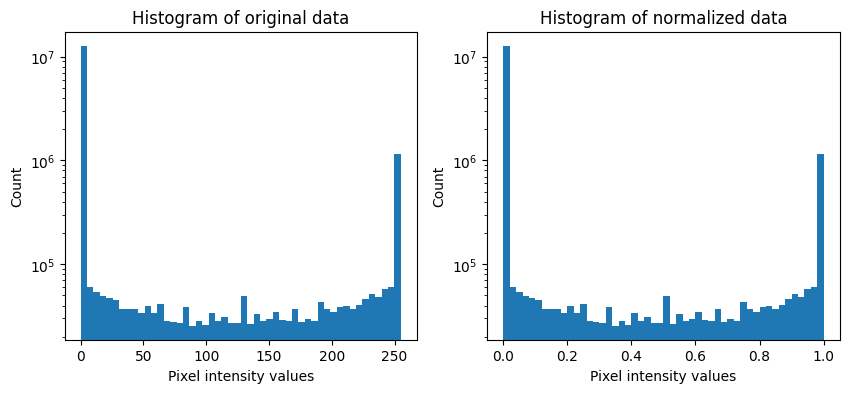

In [23]:
# normalize the data to a range of [0 1]  (just data, not labels)
dataNorm = data / np.max(data)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].hist(data.flatten(), bins=50)
ax[0].set_xlabel('Pixel intensity values')
ax[0].set_ylabel('Count')
ax[0].set_title('Histogram of original data')

ax[1].hist(dataNorm.flatten(), 50)
ax[1].set_xlabel('Pixel intensity values')
ax[1].set_ylabel('Count')
ax[1].set_title('Histogram of normalized data')

# set a log scale for y
ax[0].set_yscale('log')
ax[1].set_yscale('log')

plt.show()

# Create train/test groups using DataLoader

In [24]:
# Step 1: convert to tensor
dataT = torch.tensor(dataNorm).float()
labelsT = torch.tensor(labels).long()  # long = int64

# Step 2: use scikitlearn to split the data
train_data, test_data, train_labels, test_labels = train_test_split(dataT, labelsT, test_size=.1)

# Step 3: convert into PyTorch Datasets
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

# Step 4: translate into dataloader objects
batchsize = 32
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [25]:
# check all variables in workspace
# %whos

# Create the DL model

In [26]:
# create a class for the model
def createTheMNISTNet():
    class mnistNet(nn.Module):
        def __init__(self):
            super().__init__()

            ### input layer
            self.input = nn.Linear(784, 64)

            ### hidden layer
            self.fc1 = nn.Linear(64, 32)
            self.fc2 = nn.Linear(32, 32)

            ### output layer
            self.output = nn.Linear(32, 10)


        # forward pass
        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            return torch.log_softmax(self.output(x), axis=1)
            # NEW HERE: log-softmax the output, because I'm using NLLLoss instead of CrossEntropyLoss

    # create the model instance
    net = mnistNet()

    # loss function
    lossfun = nn.NLLLoss()

    # optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=.01)

    return net, lossfun, optimizer

In [27]:
# test the model with one batch
net, lossfun, optimizer = createTheMNISTNet()

X, y = next(iter(train_loader))
yHat = net(X)

# values are log-probability of each number (0-9)
# print(torch.exp(yHat))

# now let's compute the loss
loss = lossfun(yHat, y)

print('\nLoss:', loss.item())
# print(loss)


Loss: 2.303269863128662


# Create a function that trains the model

In [28]:
# a function that trains the model

def function2trainTheModel():
    # number of epochs
    numepochs = 60

    # create a new model
    net, lossfun, optimizer = createTheMNISTNet()

    # initialize losses
    losses = torch.zeros(numepochs)
    trainAcc = []
    testAcc = []

    # loop over epochs
    for epochi in range(numepochs):

        # loop over training data batches
        batchAcc = []
        batchLoss = []
        for X, y in train_loader:
            # forward pass and loss
            yHat = net(X)
            loss = lossfun(yHat, y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss from this batch
            batchLoss.append(loss.item())

            # compute accuracy
            matches = torch.argmax(yHat, axis=1) == y  # booleans (false/true)
            matchesNumeric = matches.float()  # convert to numbers (0/1)
            accuracyPct = 100 * torch.mean(matchesNumeric)  # average and x100
            batchAcc.append(accuracyPct)  # add to list of accuracies
        # end of batch loop...

        # now that we've trained through the batches, get their average training accuracy
        trainAcc.append(np.mean(batchAcc))

        # and get average losses across the batches
        losses[epochi] = np.mean(batchLoss)

        # test accuracy
        X, y = next(iter(test_loader))  # extract X,y from test dataloader
        yHat = net(X)

        # compare the following really long line of code to the training accuracy lines
        testAcc.append(100 * torch.mean((torch.argmax(yHat, axis=1) == y).float()))

    # end epochs

    # function output
    return trainAcc, testAcc, losses, net


# Run the model and show the results!

In [29]:
trainAcc, testAcc, losses, net = function2trainTheModel()


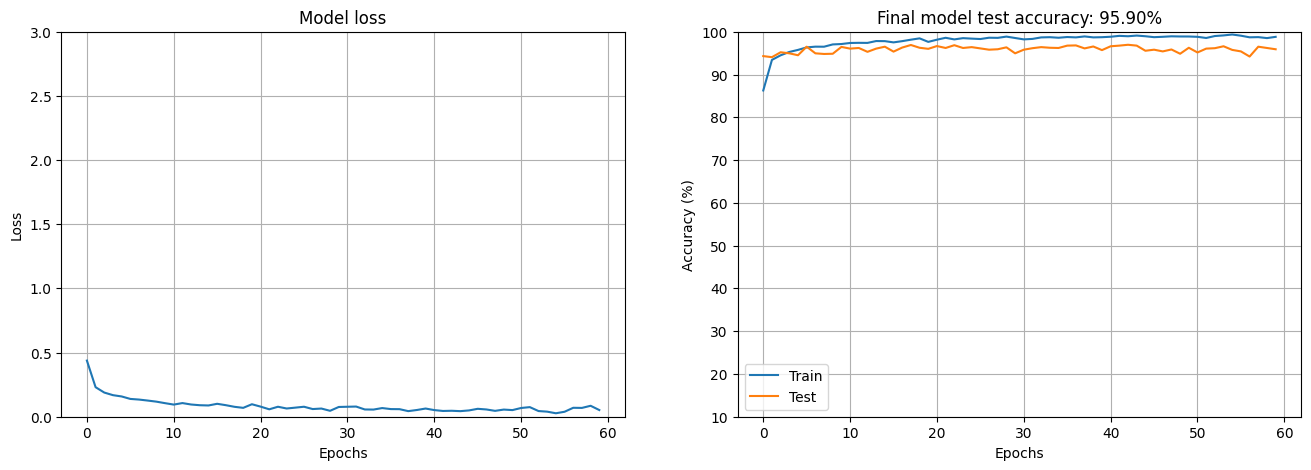

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0, 3])
ax[0].set_title('Model loss')
ax[0].grid()

ax[1].plot(trainAcc, label='Train')
ax[1].plot(testAcc, label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10, 100])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()
ax[1].grid()

plt.show()

# Inspect the results in more detail

In [31]:
# run the model through for the test data
X, y = next(iter(test_loader))
predictions = net(X).detach()

print(predictions[0].tolist())

# back to probabilities
print("\nBack to probabilities: \n", torch.exp(predictions[0]).tolist())
print()
for lab, pred in enumerate(predictions[0]):
    print(f'Number {lab} has probability {torch.exp(pred).item():.6f}')
      

[-34.26115417480469, -28.992040634155273, -16.333457946777344, -45.25647735595703, -0.00010573305189609528, -37.451534271240234, -15.235872268676758, -15.377012252807617, -39.69868850708008, -9.1598482131958]

Back to probabilities: 
 [1.3199874517600134e-15, 2.5639923127360187e-13, 8.062492895533069e-08, 2.214938133500261e-20, 0.9998942613601685, 5.432569884307338e-17, 2.4162659428839106e-07, 2.09820754548673e-07, 5.74220426710125e-18, 0.00010517886403249577]

Number 0 has probability 0.000000
Number 1 has probability 0.000000
Number 2 has probability 0.000000
Number 3 has probability 0.000000
Number 4 has probability 0.999894
Number 5 has probability 0.000000
Number 6 has probability 0.000000
Number 7 has probability 0.000000
Number 8 has probability 0.000000
Number 9 has probability 0.000105


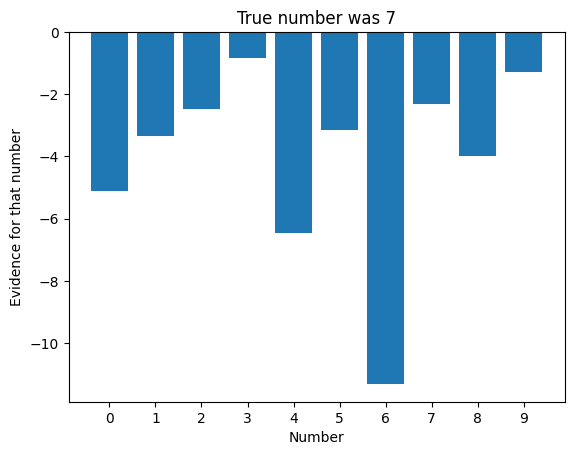

In [32]:
# Evidence for all numbers from one sample
sample2show = 120

plt.bar(range(10), predictions[sample2show])  # try adding exp!
plt.xticks(range(10))
plt.xlabel('Number')
plt.ylabel('Evidence for that number')
plt.title('True number was %s' % y[sample2show].item())
plt.show()

[   3    5   14   16   86  120  121  130  154  170  189  194  252  274
  289  292  322  326  373  382  384  427  433  442  445  461  462  470
  475  477  478  514  522  546  596  648  654  693  710  713  722  754
  844  872  893  909  910  932  983 1011 1015 1018 1030 1036 1038 1075
 1076 1101 1153 1192 1201 1206 1218 1220 1330 1349 1355 1363 1383 1436
 1490 1563 1678 1685 1790 1828 1837 1851 1883 1933 1951 1970]


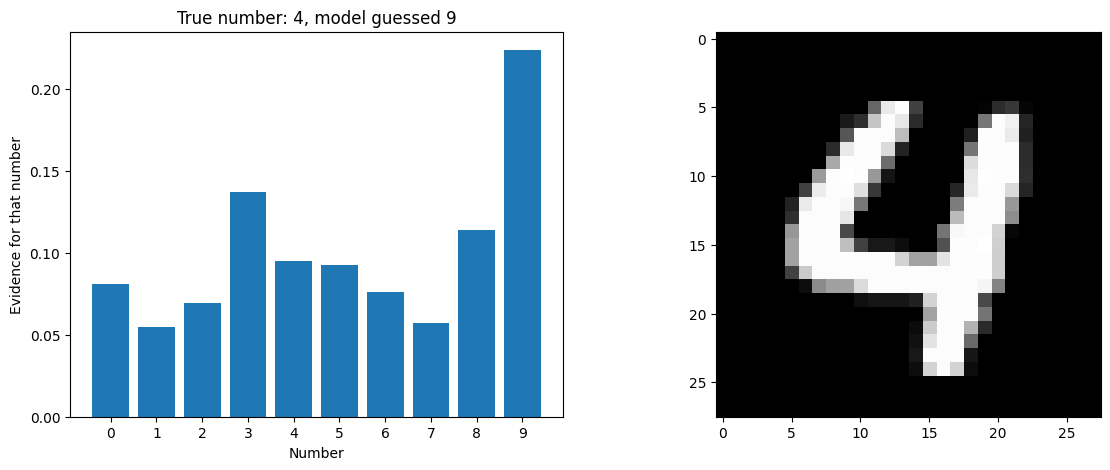

In [33]:
# find the errors
errors = np.where(torch.max(predictions, axis=1)[1] != y)[0]
print(errors)

# Evidence for all numbers from one sample
sample2show = 10

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

ax[0].bar(range(10), np.exp(predictions[errors[sample2show]]))
ax[0].set_xticks(range(10))
ax[0].set_xlabel('Number')
ax[0].set_ylabel('Evidence for that number')
ax[0].set_title('True number: %s, model guessed %s'
                % (y[errors[sample2show]].item(), torch.argmax(predictions[errors[sample2show]]).item()))

ax[1].imshow(np.reshape(X[errors[sample2show], :], (28, 28)), cmap='gray')

plt.show()

# Additional explorations

In [34]:
# 1) Average together the correct 7's and the error 7's, and make images of them (that is, one image
#    of all correct 7's and one image of all incorrectly labeled 7's). How do they look?
# 
# 2) Repeat #1 for all numbers to produce a 2x10 matrix of images with corrects on top
#    and errors on the bottom.
# 
# 3) Identify "almost errors," which we can define as correct categorizations that had a probability of
#    e.g., >.1 for any other number. Make images of some of these numbers. Can you understand why the model
#    was confused?
# 
# 4) I didn't use .train(), .eval(), or no_grad() here. Is that a problem? Can you add those in without checking
#    other notebooks?
# 